In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan
%matplotlib inline

#### 7.2 対数をとるか否か

In [2]:
df2 = pd.read_csv("input/data-rental.txt")

In [3]:
df2.head(2)

,Y,Area
0,263.062,40.66
1,519.000,61.94


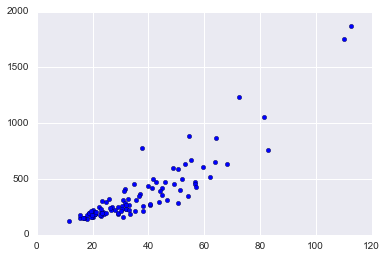

In [6]:
plt.scatter(df2.Area, df2.Y)

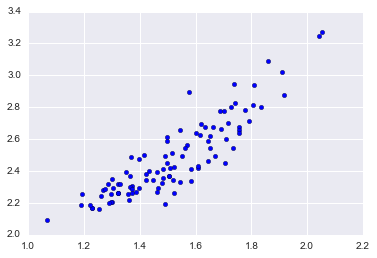

In [15]:
plt.scatter(np.log10(df2.Area), np.log10(df2.Y))

x, y軸が対数スケールになってるが、気にしない

In [21]:
Area_new = np.arange(1, 120)
data71 = {"N":len(df2), "Area":df2.Area, "Y":df2.Y, "Area_new":Area_new, "N_new":len(Area_new)}
fit71 = pystan.stan(file="stan/model7-1.stan", data=data71, seed=1234)

In [22]:
data72 = {"N":len(df2), "Area":np.log10(df2.Area), "Y":np.log10(df2.Y), "Area_new":np.log10(Area_new), "N_new":len(Area_new)}
fit72 = pystan.stan(file="stan/model7-2.stan", data=data72, seed=1234)

In [23]:
ms1 = fit71.extract()
ms2 = fit72.extract()

In [26]:
y1_new =ms1["y_new"].T
y2_new =ms2["y_new"].T

In [42]:
df_y1_new = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist() for x in y1_new],columns=["p10","p25","p50","p75","p90"])
df_y2_new = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist()  for x in y2_new],columns=["p10","p25","p50","p75","p90"])

(0, 120)

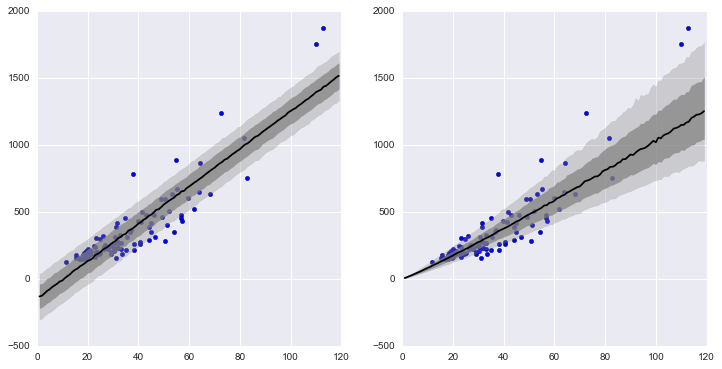

In [64]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax1.scatter(df2.Area, df2.Y)
ax1.plot(Area_new, df_y1_new.p50,color="black")
ax1.fill_between(Area_new, df_y1_new.p10, df_y1_new.p90, color="gray", alpha=0.3)
ax1.fill_between(Area_new, df_y1_new.p25, df_y1_new.p75, color="gray", alpha=0.7)
ax1.set_xlim(0,120)
ax2 = plt.subplot(1,2,2)
ax2.scatter(df2.Area, df2.Y)
ax2.plot(Area_new, 10 ** df_y2_new.p50,color="black")
ax2.fill_between(Area_new, 10 ** df_y2_new.p10, 10 ** df_y2_new.p90, color="gray", alpha=0.3)
ax2.fill_between(Area_new, 10 ** df_y2_new.p25, 10 ** df_y2_new.p75, color="gray", alpha=0.7)
ax2.set_xlim(0,120)

左80%ベイズ予測区間が負の値を含む

In [83]:
y1_pred =ms1["y_pred"].T
y2_pred =ms2["y_pred"].T
df_y1_pred = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist() for x in y1_pred],columns=["p10","p25","p50","p75","p90"])
df_y2_pred = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist()  for x in y2_pred],columns=["p10","p25","p50","p75","p90"])
df_y1_pred["y_true"] = df2.Y
df_y2_pred["y_true"] = np.log10(df2.Y)
df_y2_pred = 10 ** df_y2_pred

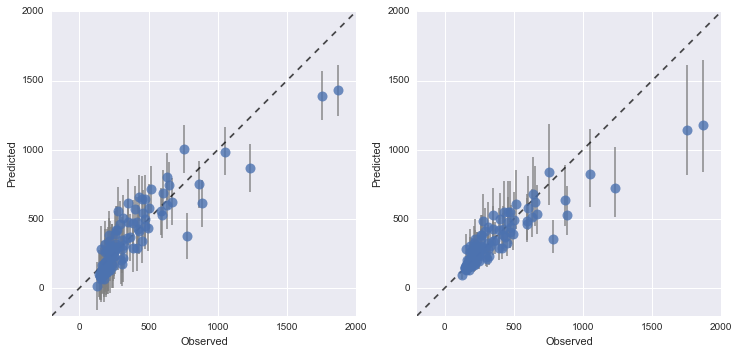

In [85]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.plot([-200,2000], [-200,2000], 'k--', alpha=0.7)
ax.errorbar(df_y1_pred.y_true, df_y1_pred.p50, yerr=[df_y1_pred.p50 - df_y1_pred.p10, df_y1_pred.p90 - df_y1_pred.p50],
    fmt='o', ecolor='gray', ms=10, alpha=0.8, marker='o')
ax.set_aspect('equal')
ax.set_xlim(-200, 2000)
ax.set_ylim(-200, 2000)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

ax = fig.add_subplot(1,2,2)
ax.plot([-200,2000], [-200,2000], 'k--', alpha=0.7)
ax.errorbar(df_y2_pred.y_true, df_y2_pred.p50, yerr=[df_y2_pred.p50 - df_y2_pred.p10, df_y2_pred.p90 - df_y2_pred.p50],
    fmt='o', ecolor='gray', ms=10, alpha=0.8, marker='o')
ax.set_aspect('equal')
ax.set_xlim(-200, 2000)
ax.set_ylim(-200, 2000)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

In [90]:
df_y1_pred = df_y1_pred.assign(eps=lambda df:df.y_true-df.p50)
df_y2_pred = df_y2_pred.assign(eps=lambda df:np.log10(df.y_true)-np.log10(df.p50))

/Users/yuki.ohnishi/.pyenv/versions/analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


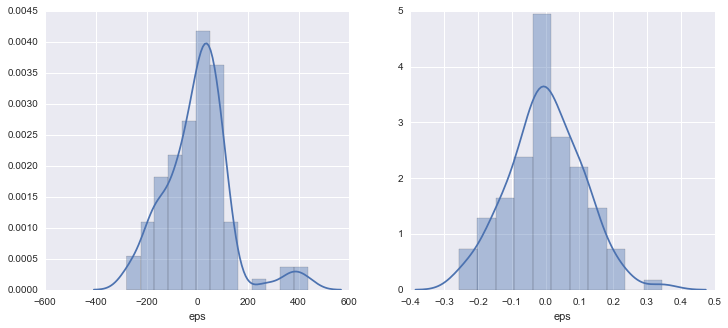

In [102]:
fig = plt.figure(figsize=(12,5))
ax1= fig.add_subplot(1,2,1)
ax1= sns.distplot(df_y1_pred.eps)
ax2= fig.add_subplot(1,2,2)
ax2= sns.distplot(df_y2_pred.eps,ax=ax2)
plt.show()

左正規分布から歪んでいる：1000万円の30%の誤差が大きく分布を歪める。一方、対数スケールで撮ると、その誤差が緩和される。

どちらを取るかは背景のメカニズム次第。対数スケールを取るのは倍々で増える仕組みが考えられる時など。

#### 7.3 非線形な関係